1. Map user ID to a "user vector" via an embedding matrix
2. Map movie ID to a "movie vector" via an embedding matrix
3. Compute the dot product between the user vector and movie vector, to obtain the a match score between the user and the movie (predicted rating).
4. Train the embeddings via gradient descent using all known user-movie pairs.

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

2025-02-03 16:02:55.998675: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-03 16:02:56.010032: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-03 16:02:56.044776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738609376.098837   49174 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738609376.116328   49174 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-03 16:02:56.170095: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# 1. Load the data and apply preprocessing

In [2]:
df = pd.read_csv("./../data/ratings.csv")
movies = pd.read_csv("./../data/tmdb_5000_movies.csv")

In [3]:
movies

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4791,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
4792,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
4793,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""

In [4]:
movies['id'].max()

np.int64(459488)

# 2. Exploratory Data Analysis

In [5]:
df.head()

,userId,movieId,rating,timestamp
0,1,1543,4.0,964982703
1,1,3110,4.0,964981247
2,1,1036,4.0,964982224
3,1,4544,5.0,964983815
4,1,2363,5.0,964982931


In [6]:
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,2389.257805,3.501557,1.205946e+09
std,182.618491,1381.688714,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1193.000000,3.000000,1.019124e+09
50%,325.000000,2386.000000,3.500000,1.186087e+09
75%,477.000000,3582.000000,4.000000,1.435994e+09
max,610.000000,4796.000000,5.000000,1.537799e+09


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [8]:
# Map user ID to a "user vector" via an embedding matrix
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

# Map movies ID to a "movies vector" via an embedding matrix
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df['rating'] = df['rating'].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(f"Number of users: {num_users}, Number of Movies: {num_movies}, Min Rating: {min_rating}, Max Rating: {max_rating}")

Number of users: 610, Number of Movies: 4796, Min Rating: 0.5, Max Rating: 5.0


In [9]:
df.head(3)

,userId,movieId,rating,timestamp,user,movie
0,1,1543,4.0,964982703,0,0
1,1,3110,4.0,964981247,0,1
2,1,1036,4.0,964982224,0,2


# 3. Preparing the Data

In [10]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values

# Normalizing the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Assuming training on 90% of the data and validating on 100%
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

# 4. Create the model

In [11]:
import sys
sys.path.append('./../saved_models')

In [12]:
from recommender_net import get_recommender_model
    
# Instancia e compila o modelo
model = get_recommender_model(num_users, num_movies, 50)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

2025-02-03 16:03:16.580323: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


# 5. Train the Model on the Data Split

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=50,
    shuffle=True,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.6759 - val_loss: 0.6403
Epoch 2/50
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.6239 - val_loss: 0.6254
Epoch 3/50
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.5941 - val_loss: 0.6285
Epoch 4/50
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.5718 - val_loss: 0.6361
Epoch 5/50
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.5553 - val_loss: 0.6442
Epoch 6/50
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.5454 - val_loss: 0.6518
Epoch 7/50
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.5371 - val_loss: 0.6588


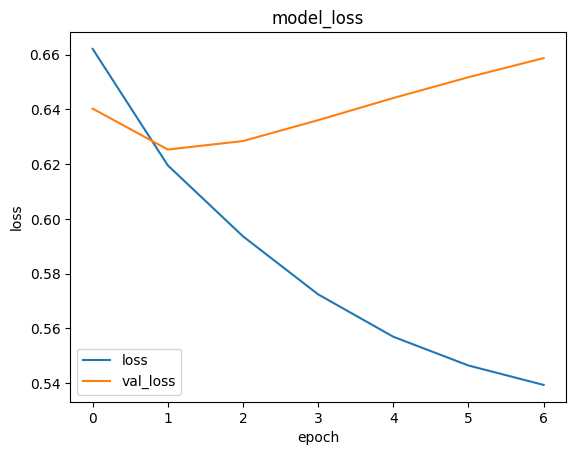

In [14]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

# 6. Show top 10 movie recommendations to a user

In [30]:
import pandas as pd
import numpy as np

def recommend_movies(user_id, num_recommendations=20):
    """
    Retorna uma lista de recomendações de filmes para um usuário específico.

    Parâmetros:
        user_id (int): ID do usuário para quem gerar recomendações.
        num_recommendations (int, opcional): Número de recomendações a serem retornadas (padrão: 20).

    Retorno:
        list: Lista contendo os títulos dos filmes recomendados e seus gêneros.
    """
    # Carregar os dados dos filmes e interações
    movie_df = pd.read_csv('./../data/tmdb_5000_movies.csv')
    df = pd.read_csv('./../data/ratings.csv')  # Arquivo com interações usuário-filme

    # Obter os filmes assistidos pelo usuário
    movies_watched_by_user = df[df.userId == user_id]

    # Identificar filmes não assistidos pelo usuário
    movies_not_watched = movie_df[~movie_df['id'].isin(movies_watched_by_user.movieId.values)]['id']
    movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

    # Codificar o usuário
    user_encoder = user2user_encoded.get(user_id)

    # Criar a matriz de entrada para predição
    user_movie_array = np.hstack(
        ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
    )

    # Fazer predições de ratings para os filmes não assistidos
    ratings = model.predict(user_movie_array).flatten()

    # Selecionar os 'num_recommendations' melhores filmes
    top_ratings_indices = ratings.argsort()[-num_recommendations:][::-1]
    recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices]

    # Obter informações dos filmes recomendados
    recommended_movies = movie_df[movie_df["id"].isin(recommended_movie_ids)]
    
    recommendations = [(row.title, row.genres) for row in recommended_movies.itertuples()]
    
    return recommendations

df = pd.read_csv('./../data/ratings.csv')
user_id_sample = df.userId.sample(1).iloc[0]
recommended_movies = recommend_movies(user_id_sample)

print(f"Showing recommendations for user: {user_id_sample}")
print("=" * 36)
print("Top movie recommendations")
print("-" * 32)
for title, genres in recommended_movies:
    print(f"{title} : {genres}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Showing recommendations for user: 222
Top movie recommendations
--------------------------------
Mission: Impossible II : [{"id": 12, "name": "Adventure"}, {"id": 28, "name": "Action"}, {"id": 53, "name": "Thriller"}]
Catwoman : [{"id": 28, "name": "Action"}, {"id": 80, "name": "Crime"}]
Zodiac : [{"id": 80, "name": "Crime"}, {"id": 18, "name": "Drama"}, {"id": 9648, "name": "Mystery"}, {"id": 53, "name": "Thriller"}]
Batman Returns : [{"id": 28, "name": "Action"}, {"id": 14, "name": "Fantasy"}]
The Simpsons Movie : [{"id": 16, "name": "Animation"}, {"id": 35, "name": "Comedy"}, {"id": 10751, "name": "Family"}]
Two Brothers : [{"id": 12, "name": "Adventure"}, {"id": 18, "name": "Drama"}, {"id": 10751, "name": "Family"}]
Austin Powers in Goldmember : [{"id": 35, "name": "Comedy"}, {"id": 80, "name": "Crime"}, {"id": 878, "name": "Science Fiction"}]
300 : [{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 10752, "name": "War"}]
F

# 7. Salvar o modelo

In [16]:
model.save('my_model.keras')

# 8. Carregar o modelo

In [17]:
# Carregar o modelo salvo
loaded_model = keras.models.load_model("my_model.keras")

In [40]:
import pandas as pd
import numpy as np

def new_recommend_movies(model, user_id, num_recommendations=20):
    """
    Retorna uma lista de recomendações de filmes para um usuário específico.

    Parâmetros:
        user_id (int): ID do usuário para quem gerar recomendações.
        num_recommendations (int, opcional): Número de recomendações a serem retornadas (padrão: 20).

    Retorno:
        list: Lista contendo os títulos dos filmes recomendados e seus gêneros.
    """
    # Carregar os dados dos filmes e interações
    movie_df = pd.read_csv('./../data/tmdb_5000_movies.csv')
    df = pd.read_csv('./../data/ratings.csv')  # Arquivo com interações usuário-filme

    print(f'user_id é {user_id}')

    # Obter os filmes assistidos pelo usuário
    movies_watched_by_user = df[df.userId == user_id]

    # Identificar filmes não assistidos pelo usuário
    movies_not_watched = movie_df[~movie_df['id'].isin(movies_watched_by_user.movieId.values)]['id']
    movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

    # Codificar o usuário
    user_encoder = user2user_encoded.get(user_id)

    # Criar a matriz de entrada para predição
    user_movie_array = np.hstack(
        ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
    )

    # Fazer predições de ratings para os filmes não assistidos
    ratings = model.predict(user_movie_array).flatten()

    # Selecionar os 'num_recommendations' melhores filmes
    top_ratings_indices = ratings.argsort()[-num_recommendations:][::-1]
    recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices]

    # Obter informações dos filmes recomendados
    recommended_movies = movie_df[movie_df["id"].isin(recommended_movie_ids)]
    
    recommendations = [(row.title, row.genres) for row in recommended_movies.itertuples()]
    
    return recommendations, ratings

In [49]:
df = pd.read_csv('./../data/ratings.csv')
user_id_sample = df.userId.iloc[0]
recommended_movies, ratings = new_recommend_movies(loaded_model, user_id_sample)

print(f"Showing recommendations for user: {user_id_sample}")
print("=" * 36)
print("Top movie recommendations")
print("-" * 32)
for title, genres in recommended_movies:
    print(f"{title} : {genres}")

user_id é 1
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Showing recommendations for user: 1
Top movie recommendations
--------------------------------
Spider-Man 3 : [{"id": 14, "name": "Fantasy"}, {"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}]
Mission: Impossible II : [{"id": 12, "name": "Adventure"}, {"id": 28, "name": "Action"}, {"id": 53, "name": "Thriller"}]
Kingdom of Heaven : [{"id": 18, "name": "Drama"}, {"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 36, "name": "History"}, {"id": 10752, "name": "War"}]
Zodiac : [{"id": 80, "name": "Crime"}, {"id": 18, "name": "Drama"}, {"id": 9648, "name": "Mystery"}, {"id": 53, "name": "Thriller"}]
Big Fish : [{"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 18, "name": "Drama"}]
Kill Bill: Vol. 2 : [{"id": 28, "name": "Action"}, {"id": 80, "name": "Crime"}, {"id": 53, "name": "Thriller"}]
Moulin Rouge! : [{"id": 18, "name": "Drama"}, {"id": 10402, "name": "Music"}, {"id": 10749, "name"

In [39]:
ratings

array([0.58777523, 0.59906137, 0.5989903 , 0.5630254 , 0.61180615,
       0.5776563 , 0.5969164 , 0.5943027 , 0.5813838 , 0.5973493 ,
       0.5817383 , 0.58519614, 0.60826254, 0.59188735, 0.59389913,
       0.5477272 , 0.6308543 , 0.60180825, 0.5469995 , 0.60318154,
       0.56870455, 0.5724336 , 0.5535289 , 0.579537  , 0.56225854,
       0.5104394 , 0.59955543, 0.6039402 , 0.5978345 , 0.58670783,
       0.5701534 , 0.59287465, 0.5959635 , 0.5902614 , 0.5974475 ,
       0.6124571 , 0.5453039 , 0.56862223, 0.62356555, 0.5764036 ,
       0.5940742 , 0.54723823, 0.59395456, 0.5485964 , 0.5887739 ,
       0.5751755 , 0.6131621 , 0.6027393 , 0.5559161 , 0.5911693 ,
       0.49404913, 0.575228  , 0.5968552 , 0.5786215 , 0.5684032 ,
       0.5666041 , 0.57512224, 0.5667459 , 0.6176862 , 0.58804965,
       0.566928  , 0.563086  , 0.5880862 , 0.59328914, 0.59892577,
       0.55361176, 0.5334711 , 0.5740182 , 0.6017763 , 0.6240836 ,
       0.5799823 , 0.54373926, 0.58035195, 0.60855764, 0.52237

In [24]:
recommended_movies = recommend_movies(user_id_sample)

print(f"Showing recommendations for user: {user_id_sample}")
print("=" * 36)
print("Top movie recommendations")
print("-" * 32)
for title, genres in recommended_movies:
    print(f"{title} : {genres}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Showing recommendations for user: 219
Top movie recommendations
--------------------------------
Spider-Man 3 : [{"id": 14, "name": "Fantasy"}, {"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}]
Catwoman : [{"id": 28, "name": "Action"}, {"id": 80, "name": "Crime"}]
Zodiac : [{"id": 80, "name": "Crime"}, {"id": 18, "name": "Drama"}, {"id": 9648, "name": "Mystery"}, {"id": 53, "name": "Thriller"}]
Two Brothers : [{"id": 12, "name": "Adventure"}, {"id": 18, "name": "Drama"}, {"id": 10751, "name": "Family"}]
Jurassic Park : [{"id": 12, "name": "Adventure"}, {"id": 878, "name": "Science Fiction"}]
All the King's Men : [{"id": 18, "name": "Drama"}, {"id": 53, "name": "Thriller"}]
Moulin Rouge! : [{"id": 18, "name": "Drama"}, {"id": 10402, "name": "Music"}, {"id": 10749, "name": "Romance"}]
The First Wives Club : [{"id": 35, "name": "Comedy"}]
eXistenZ : [{"id": 28, "name": "Action"}, {"id": 53, "name": "Thriller"}, {"id": 878, "name": "Scie